In [1]:
import torch
import torch.nn as nn

import math
from functools import partial
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage import uniform_filter1d
import sys
import time
import cv2

sys.path.append('/home/oscar_palfelt/MSc_thesis/ompl/py-bindings')
from ompl import base as ob
from ompl import control as oc
from ompl import geometric as og

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

In [2]:
# generate random gridMaps

def getRndRoadgrid(gridSize, maxVRT=3, maxHOR=3):

    VRT = - 10 * np.ones(maxVRT)
    HOR = - 10 * np.ones(maxHOR)

    nVRT = np.random.randint(1, maxVRT+1)
    nHOR = np.random.randint(1, maxHOR+1)

    for i in range(nVRT):
        vrt = np.random.randint(0, gridSize) / gridSize
        while (np.abs(vrt - VRT) < 3/gridSize).any():
            vrt = np.random.randint(0, gridSize) / gridSize

        VRT[i:] = vrt

    for i in range(nHOR):
        hor = np.random.randint(0, gridSize) / gridSize

        while (np.abs(1 - hor - HOR) < 3/gridSize).any():
            hor = np.random.randint(0, gridSize) / gridSize

        HOR[i:] = 1 - hor

    VRT.sort(), HOR.sort()

    return VRT, HOR

In [25]:
# function to calculate centepoints of each road intersection crossed by the planner

def getIntermediateStartGoal(VRT, HOR, ssol, gridSize):
    crossings = -1 * np.ones(shape=(1,2))
    for i in range(ssol.shape[0]):

        dCrossVRT = np.abs(ssol[i,0] - VRT)
        dCrossHOR = np.abs(ssol[i,1] - HOR)

        if (dCrossVRT < 0.12).any() and (dCrossHOR < 0.12).any():
            crossVRT = VRT[np.argmin(dCrossVRT)]
            crossHOR = HOR[np.argmin(dCrossHOR)]

            cross = np.clip(np.array([crossVRT - .5/gridSize, crossHOR + .5/gridSize]), .5 / gridSize, (gridSize - .5) / gridSize)

            if not (crossings[-1] == cross).all():
                crossings = np.vstack((crossings, cross))

    crossings = crossings[1:]

    diffCrossings = np.diff(np.concatenate((start[:2].reshape(1,2), crossings, goal[:2].reshape(1,2))), axis=0)
    interStarts = np.copy(crossings)
    interGoals = np.copy(crossings)

    startAxis = np.argmax(np.abs(diffCrossings[:-1]), axis=1)
    startSign = np.sign(diffCrossings[np.arange(diffCrossings.shape[0] - 1), startAxis])
    interStarts[np.arange(interStarts.shape[0]), startAxis] -= 1.5/gridSize * startSign

    goalAxis = np.argmax(np.abs(diffCrossings[1:]), axis=1)
    goalSign = np.sign(diffCrossings[np.arange(1, diffCrossings.shape[0]), goalAxis])
    interGoals[np.arange(interGoals.shape[0]), goalAxis] += 1.5/gridSize * goalSign

    interStartYaw =-np.pi * (startAxis == 0).astype(int) * (startSign == -1).astype(int) + (startAxis == 1).astype(int) * (np.pi/2 - np.pi * (startSign == -1).astype(int))
    interGoalYaw = -np.pi * (goalAxis == 0).astype(int) * (goalSign == -1).astype(int) + (goalAxis == 1).astype(int) * (np.pi/2 - np.pi * (goalSign == -1).astype(int))

    return np.hstack((interStarts, interStartYaw.reshape(interStarts.shape[0], 1))), np.hstack((interGoals, interGoalYaw.reshape(interGoals.shape[0], 1)))

In [60]:
def propagateState(traj_x, traj_y, truckState, trailerState, statelist):
    controller = PurePursuitController()

    controller.traj_x = traj_x
    controller.traj_y = traj_y

    delta = controller.compute_control(truckState)

    ctrliter = 0
    while not controller.is_finished and ctrliter < maxCtrlIter:
        
        delta = (delta + controller.compute_control(truckState)) / 2 # helps smoothen steering input
        beta = np.arctan(np.tan(delta) * a12 / (a11 + a12))

        trailerState.x = truckState.x - b1 * np.cos(truckState.yaw) - 0.8 * b2 * np.cos(trailerState.yaw)
        trailerState.y = truckState.y - b1 * np.sin(truckState.yaw) - 0.8 * b2 * np.sin(trailerState.yaw)
        trailerState.yaw += (v * np.sin(truckState.yaw - trailerState.yaw) / (b2 + a21) - v * (b1 - a12) * np.cos(truckState.yaw - trailerState.yaw) * np.sin(beta) / (a12 * (b2 + a21))) * dt

        truckState.x += v * np.cos(truckState.yaw + beta) * dt
        truckState.y += v * np.sin(truckState.yaw + beta) * dt
        truckState.yaw += v * np.sin(beta) / a12 * dt

        statelist.append([truckState.x, truckState.y, truckState.yaw, trailerState.yaw, delta, trailerState.x, trailerState.y]) 

        ctrliter += 1

    if not controller.is_finished:
        raise UserWarning('Exceeded max ctrl iter')

    return statelist

In [176]:
# define planning problem
class MyGoal(ob.Goal):
    def __init__(self, si, goal):
        super(MyGoal, self).__init__(si)
        self.goal = goal

    def isSatisfied(self, state):
        return np.linalg.norm(self.goal - np.array([state[0], state[1], (state[2] + np.pi) % (2 * np.pi) - np.pi])) < 0.04


def getThresholdPathLengthObj(si):
     obj = ob.PathLengthOptimizationObjective(si)
     obj.setCostThreshold(ob.Cost(4.0))
     return obj


def isRV2StateValid(spaceInformation, state):
    # perform collision checking or check if other constraints are
    # satisfied

    u = int(np.floor(state[0] * gridSize)) # right pointing image axis
    v = int(np.floor(gridSize * (1 - state[1]))) # down pointing image axis

    if spaceInformation.satisfiesBounds(state):
        return occGrid[v,u] > 0


def isRV4Valid(spaceInformation, state):
    # perform collision checking or check if other constraints are
    # satisfied

    uTruck = int(np.floor(state[0] * gridSize)) # right pointing image axis
    vTruck = int(np.floor(gridSize * (1 - state[1]))) # down pointing image axis

    xTrailer = state[0] - b1 * np.cos(state[2]) - np.linspace(0, b2, 6) * np.cos(state[3])
    yTrailer = state[1] - b1 * np.sin(state[2]) - np.linspace(0, b2, 6) * np.sin(state[3])
    uTrailer = np.clip(np.floor(xTrailer * gridSize), 0, gridSize - 1).astype(int)
    vTrailer = np.clip(np.floor(gridSize * (1 - yTrailer)), 0, gridSize - 1).astype(int)

    #return True
    if spaceInformation.satisfiesBounds(state):
        return occGrid[vTruck,uTruck] > 0 and (occGrid[vTrailer,uTrailer] > 0).all() 


def propagate(start, control, duration, state):
    # global exploredStates
    # exploredStates = np.vstack((exploredStates, np.array([[state.getX(), state.getY(), state.getYaw()]])))

    beta = np.arctan(np.tan(control[0]) * a12 / (a11 + a12))

    state[0] = start[0] + v * np.cos(start[2] + beta) * duration
    state[1] = start[1] + v * np.sin(start[2] + beta) * duration
    state[2] = start[2] + v * np.sin(beta) / a12 * duration
    state[3] = start[3] + (v * np.sin(start[2] - start[3]) / (b2 + a21) - v * (b1 - a12) * np.cos(start[2] - start[3]) * np.sin(beta) / (a12 * (b2 + a21))) * duration


def problemDef(sampleCtrl=False):

    if sampleCtrl:
        # construct the state space we are planning in
        space = ob.RealVectorStateSpace(4)

        # # set the bounds for the R^2 part of SE(2)
        bounds = ob.RealVectorBounds(4)
        bounds.setLow(0, 0.001)
        bounds.setLow(1, 0.001)
        bounds.setLow(2, -2 * np.pi)
        bounds.setLow(3, -2 * np.pi)
        bounds.setHigh(0, 0.999)
        bounds.setHigh(1, 0.999)
        bounds.setHigh(2, 2 * np.pi)
        bounds.setHigh(3, 2 * np.pi)
        space.setBounds(bounds)

        # create a control space
        cspace = oc.RealVectorControlSpace(space, 1)

        # set the bounds for the control space
        cbounds = ob.RealVectorBounds(1)
        cbounds.setLow(-0.8)
        cbounds.setHigh(0.8)
        cspace.setBounds(cbounds)

        ss = oc.SimpleSetup(cspace)
        ss.setStatePropagator(oc.StatePropagatorFn(propagate))
        si = ss.getSpaceInformation()

        si.setPropagationStepSize(.07)
        si.setMinMaxControlDuration(1, 1)
        planner = oc.RRT(si)

        ss.setStateValidityChecker(ob.StateValidityCheckerFn( \
            partial(isRV4Valid, ss.getSpaceInformation())))

    else:
        # construct the state space we are planning in
        space = ob.RealVectorStateSpace(2)

        # set the bounds for the R^2 part of SE(2)
        bounds = ob.RealVectorBounds(2)
        bounds.setLow(0.001)
        bounds.setHigh(0.999)
        space.setBounds(bounds)

        # define a simple setup class
        ss = og.SimpleSetup(space)
        si = ss.getSpaceInformation()
        planner = og.RRTstar(si)

        ss.setStateValidityChecker(ob.StateValidityCheckerFn( \
            partial(isRV2StateValid, ss.getSpaceInformation())))

    ss.setPlanner(planner)
    ss.getProblemDefinition().setOptimizationObjective(getThresholdPathLengthObj(si))
    
    return ss


def plan(planObj, initState, goalState, simplify=False):

    if simplify:    
        space = ob.RealVectorStateSpace(2)

        start = ob.State(space)
        start[0] = initState[0]
        start[1] = initState[1]

        goal = ob.State(space)
        goal[0] = goalState[0]
        goal[1] = goalState[1]

        planObj.setStartAndGoalStates(start, goal, 0.02)

        timeTerminationCondition = ob.timedPlannerTerminationCondition(2.)
    else:
        space = ob.RealVectorStateSpace(4)

        start = ob.State(space)
        start[0] = initState[0] # truck x
        start[1] = initState[1] # truck y
        start[2] = initState[2] # truck yaw
        start[3] = initState[3] # trailer yaw

        si = planObj.getSpaceInformation()
        planObj.setStartState(start)
        planObj.setGoal(MyGoal(si, goalState))

        timeTerminationCondition = ob.timedPlannerTerminationCondition(1.4)

    costTerminationCondition = ob.CostConvergenceTerminationCondition(planObj.getProblemDefinition(), solutionsWindow=4, epsilon=1.0)

    solved = planObj.solve(ob.plannerOrTerminationCondition(costTerminationCondition, timeTerminationCondition))

    if simplify and solved:
        planObj.simplifySolution()

In [6]:
class PurePursuitController():

    k = 0.06  # look forward gain
    Lfc = 0.06  # look-ahead distance
    K_p = 1.2  #TODO speed control propotional gain
    K_i = 5.0  #TODO speed control integral gain
    K_d = 0.008  # speed control derivitive gain
    L = 0.0724  # [m] wheel base of vehicle

    def __init__(self):
        self.traj_x = []
        self.traj_y = []
        self.target = None
        self.max_vel = 0.7
        # initialize with 0 velocity
        self.target_velocity = 0.0
        self.last_index = 0
        self.last_d = 100
        self.dt = 0.01
        self.vel_error_int_sum = 0
        self.vel_error = np.array([0])  
        self.vel_error_int = np.array([0]) 
        self.vel_error_der = np.array([0]) 
        self.is_finished = False

    def compute_control(self, state, target=None):
        steering = self.compute_steering(state, target)
        velocity = self.compute_velocity(state)
        return steering

    def compute_steering(self, state, target=None):
        if target is None:
            self.find_target(state)
        else:
            # allow manual setting of target
            self.target = target

        tx, ty = self.target
        alpha = np.arctan2(ty - state.y, tx - state.x) - state.yaw
        if state.v < 0:  # back
            alpha = np.pi - alpha
        Lf = self.k * state.v + self.Lfc
        delta = np.arctan2(2.0 * self.L * 0.5 * np.sin(alpha) / Lf, 1.0)
        return delta
                                   
    def compute_velocity(self, state):
        if self.is_finished:
            # stop moving if trajectory done
            return 0.0
        else:
            # speed control
            # Append the errors to the lists2
            self.vel_error     = np.append(self.vel_error      , self.target_velocity - state.v)
            self.vel_error_int = np.append(self.vel_error_int  , self.vel_error_int[-1] + self.vel_error[-1] * self.dt)
            self.vel_error_der = np.append(self.vel_error_der  , (self.vel_error[-1] - self.vel_error[-2]) / self.dt)

            P = self.vel_error[-1] * self.K_p
            I = self.vel_error_int[-1] * self.K_i
            D = self.vel_error_der[-1] * self.K_d

            correction = P + I + D

            # Saturating the velocity at a max velocity
            return self.target_velocity + min(correction, 0)

    def find_target(self, state):
        ind = self._calc_target_index(state)
        self.last_index = ind
        tx = self.traj_x[ind]
        ty = self.traj_y[ind]
        self.target = (tx, ty)

    def _calc_target_index(self, state):
        # search nearest point index
        dx = [state.x - icx for icx in self.traj_x]
        dy = [state.y - icy for icy in self.traj_y]
        d = [abs(np.sqrt(idx ** 2 + idy ** 2)) for (idx, idy) in zip(dx, dy)]
        ind = d.index(min(d))
        dist = 0.0
        Lf = self.k * state.v + self.Lfc

        # search look ahead target point index
        while Lf > dist and (ind + 1) < len(self.traj_x):
            dx = self.traj_x[ind + 1] - self.traj_x[ind]
            dy = self.traj_y[ind + 1] - self.traj_y[ind]
            dist += np.sqrt(dx ** 2 + dy ** 2)
            ind += 1

        # terminating condition
        if ind >= len(self.traj_x) - 1 and d[-1] < 0.08:
            self.is_finished = True

        return ind


class VehicleState():
    def __init__(self):
        self.x = 0
        self.y = 0
        self.yaw = 0
        self.v = 0

In [175]:
# generate planning scenario, plan, and perform path following

nData = 30
minDistThreshold = 0.8 # minimum distance threshold betwen start/goal
pdef = problemDef(sampleCtrl=False)
pdef_ctrl = problemDef(sampleCtrl=True)
maxCtrlIter = 60
maxInitIter = 1000
gridSize = 11

dt = 0.2 # controller time step
v =  0.1 # vehicle speed
L   = 0.05 # vehicle length constant
Lt  = 0.18 # truck length constant
a11 = 0.5 * L
a12 = L - a11
b1  = 0.9 * a12
b2  = 0.5 * Lt 
a21 = Lt - b2

trajSamples = np.zeros(shape=(1, 7)) # truckX, truckY, truckYaw, trailerX, trailerY trailerYaw, steer
initData = np.zeros(shape=(1, 3)) # x, y, yaw
goalData = np.zeros(shape=(1, 3))
obstacleData = np.zeros(shape=(1, 6))
data = np.zeros(shape=(1, trajSamples.shape[1] + initData.shape[1] + goalData.shape[1] + obstacleData.shape[1]))

# exploredStates = np.zeros(shape=(1, 3))

plotPaths = False

nPlans = 0
while nPlans < nData:

    occGrid = np.zeros(shape=(gridSize, gridSize))
    intersectGrid = np.copy(occGrid) + 1
    VRT, HOR = getRndRoadgrid(gridSize, maxVRT=3, maxHOR=3)
    VRTv, HORv = np.meshgrid((VRT * (gridSize - 1)).astype(int), ((1 - HOR) * (gridSize - 1)).astype(int), indexing='ij')

    occGrid[:, (VRT * (gridSize - 1)).astype(int)] = 1
    occGrid[((1 - HOR) * (gridSize - 1)).astype(int), :] = 1
    intersectGrid[HORv.reshape(-1), VRTv.reshape(-1)] = 0
    intersectGrid = np.floor(cv2.blur(intersectGrid, ksize=(3,3)))

    # generate starting point and goal using simple planner
    while True:
        initIter = 0
        while True and initIter < maxInitIter: # randomize starting coordinates
            initIter += 1

            start = np.array([np.random.uniform(low=0.001, high=0.999), np.random.uniform(low=0.001, high=0.999), 0])
            goal  = np.array([np.random.uniform(low=0.001, high=0.999), np.random.uniform(low=0.001, high=0.999), 0])
            
            uStart = int(np.floor(start[0] * gridSize)) # right pointing image axis
            vStart = int(np.floor(gridSize * (1 - start[1]))) # down pointing image axis
            uGoal = int(np.floor(goal[0] * gridSize)) # right pointing image axis
            vGoal = int(np.floor(gridSize * (1 - goal[1]))) # down pointing image axis
            if np.abs(start[:2] - goal[:2]).sum() > minDistThreshold and occGrid[vStart,uStart] > 0 and occGrid[vGoal,uGoal] > 0 and intersectGrid[vStart,uStart] > 0 and intersectGrid[vGoal,uGoal]:
                break

        pdef.clear()
        plan(pdef, initState=start, goalState=goal, simplify=True)
        if pdef.getProblemDefinition().hasExactSolution() and not np.any(goalData[-1,:2] == goal[:2]): # ignore paths that consequtively start in the same pose
            break

    ssol = np.loadtxt(StringIO(pdef.getProblemDefinition().getSolutionPath().printAsMatrix()))
    
    # remove points unneccesarily close to start/goal
    ssol = ssol[1:] if np.linalg.norm(ssol[0, :2] - start[:2]) < 0.02 else ssol
    ssol = ssol[:-1] if np.linalg.norm(ssol[-1, :2] - goal[:2]) < 0.02 else ssol

    if ssol.shape[0] > 0:

        # find suitable starting/goal yaw to be used by control planner
        start_dxdy = ssol[0, :2] - start[:2]; goal_dxdy = goal[:2] - ssol[-1, :2]
        start_xydot = start_dxdy / np.linalg.norm(start_dxdy); goal_xydot = goal_dxdy / np.linalg.norm(goal_dxdy)
        start[-1] = np.sign(int(start_xydot[-1] > 0) - 0.5) * np.arccos(np.dot(start_xydot / np.linalg.norm(start_xydot), [1, 0])) # get yaw from xdot, ydot
        goal[-1] = np.sign(int(goal_xydot[-1] > 0)- 0.5) * np.arccos(np.dot(goal_xydot / np.linalg.norm(goal_xydot), [1, 0]))

        truckState = VehicleState()
        truckState.x = start[0]; truckState.y = start[1]; truckState.yaw = start[2]; truckState.v = v

        trailerState = VehicleState()
        trailerState.yaw = truckState.yaw
        trailerState.x = truckState.x - b1 * np.cos(trailerState.yaw) - b2 * np.cos(trailerState.yaw)
        trailerState.y = truckState.y - b1 * np.sin(trailerState.yaw) - b2 * np.sin(trailerState.yaw)

        # perform control planning near each 90 degree turn
        interStarts, interGoals = getIntermediateStartGoal(VRT, HOR, ssol, gridSize)

        statelist = [[truckState.x, truckState.y, truckState.yaw, trailerState.yaw, 0, trailerState.x, trailerState.y]]

        replan = False
        for startI, goalI in zip(interStarts, interGoals):

            try:    
                statelist = propagateState(traj_x=[startI[0]], traj_y=[startI[1]], truckState=truckState, trailerState=trailerState, statelist=statelist)
            except: 
                replan = True
                break

            pdef_ctrl.clear()
            plan(pdef_ctrl, initState=[truckState.x, truckState.y, truckState.yaw, trailerState.yaw], goalState=goalI)
            if not pdef_ctrl.getProblemDefinition().hasExactSolution():
                replan = True
                break

            csol = np.loadtxt(StringIO(pdef_ctrl.getProblemDefinition().getSolutionPath().printAsMatrix()))

            try:    
                statelist = propagateState(traj_x=csol[:,0], traj_y=csol[:,1], truckState=truckState, trailerState=trailerState, statelist=statelist)
            except: 
                replan = True
                break

        if replan:
            continue

        try:
            statelist = propagateState(traj_x=[goal[0]], traj_y=[goal[1]], truckState=truckState, trailerState=trailerState, statelist=statelist)
        except:
            print("\n \n failed state prop \n \n")
            break

        nSteps = len(statelist)
        statearr = np.array(statelist).reshape(-1).reshape(nSteps, len(statelist[0]))

        trajSamples = np.vstack((trajSamples, statearr)) # x, y, yaw, yawTrailer, steer
        initData = np.vstack((initData, np.tile(start, reps=(nSteps, 1)))) # x, y, yaw
        goalData = np.vstack((goalData, np.tile(goal, reps=(nSteps, 1))))
        obstacleData = np.vstack((obstacleData, np.tile(np.concatenate((VRT, HOR)), reps=(nSteps, 1))))

        if plotPaths:
            plt.figure(figsize=(6,6), dpi=80)
            plt.imshow(occGrid, extent=[0, gridSize, 0, gridSize], cmap='gray')
            plt.plot(statearr[:,0] * gridSize, statearr[:,1] * gridSize, color='purple')
            plt.plot(statearr[:,5] * gridSize, statearr[:,6] * gridSize, color='C0')
            plt.scatter(interStarts[:,0] * gridSize, interStarts[:,1] * gridSize)
            plt.scatter(interGoals[:,0] * gridSize, interGoals[:,1] * gridSize)
            plt.plot(csol[:,0] * gridSize, csol[:,1] * gridSize, color='green')
            plt.quiver(start[0] * gridSize, start[1] * gridSize, np.cos(start[2]), np.sin(start[2]), color="red", scale=8.0, width=0.015) # init
            plt.quiver(goal[0] * gridSize, goal[1] * gridSize, np.cos(goal[2]), np.sin(goal[2]), color="blue", scale=8.0, width=0.015) # goal
            plt.show()

        if nPlans % 300 == 0: # alleviate stacking of large matrices
            data = np.vstack((data, np.concatenate((trajSamples[1:], initData[1:], goalData[1:], obstacleData[1:]), axis=1))) 

            if nPlans % 900 == 0: # save progress in case of error
                np.savetxt('/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/truck_trailer/motion_planning/data/ctrlTrailerGrid' + str(nPlans), data[1:], delimiter=',', fmt='%1.6f')

            # alleviate stacking of large matrices
            trajSamples = np.zeros(shape=(1, 7))
            initData = np.zeros(shape=(1, 3))
            goalData = np.zeros(shape=(1, 3))
            obstacleData = np.zeros(shape=(1, 6))

        nPlans += 1


Debug:   RRTstar: Planner range detected to be 0.282277
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 0.92 in 134 iterations (19 vertices in the graph)
Info:    RRTstar: Created 18 new states. Checked 171 rewire options. 1 goal states in tree. Final solution cost 0.920
Info:    Solution found in 0.002429 seconds
Info:    SimpleSetup: Path simplification took 0.005339 seconds and changed from 5 to 4 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1033 states
Info:    Solution found in 0.600062 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 0.93 in 139 iteration

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1128 states
Info:    Solution found in 0.600178 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.19 in 189 iterations (74 vertices in the graph)
Info:    RRTstar: Created 73 new states. Checked 2701 rewire options. 1 goal states in tree. Final solution cost 1.195
Info:    Solution found in 0.012339 seconds
Info:    SimpleSetup: Path simplification took 0.003965 seconds and changed from 8 to 4 states
Debug:   RRT: Discarded start state RealVectorState [0.505024 0.267577 -3.02462 -3.02462]

Info:    No solution found after 0.000425 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.32 i

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1048 states
Info:    Solution found in 0.600322 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.12 in 35 iterations (11 vertices in the graph)
Info:    RRTstar: Created 10 new states. Checked 55 rewire options. 1 goal states in tree. Final solution cost 1.118
Info:    Solution found in 0.001248 seconds
Info:    SimpleSetup: Path simplification took 0.005088 seconds and changed from 7 to 3 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    RRT: Created 772 states
Info:    Solution found in 0.300558 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 908 states
Info:    Solution found in 0.600052 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.51 in 118 iterations (33 vertices in the graph)
Info:    RRTstar: Created 32 new states. Checked 528 rewire options. 1 goal states in tree. Final solution cost 1.514
Info:    Solution found in 0.003878 seconds
Info:    SimpleSetup: Path simplification took 0.005701 seconds and changed from 9 to 6 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    RRT: Created 1089 states
Info:    Solution found in 0.516705 seconds
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 921 states
Info:    Solution fo

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 895 states
Info:    Solution found in 0.600058 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.33 in 150 iterations (36 vertices in the graph)
Info:    RRTstar: Created 35 new states. Checked 630 rewire options. 1 goal states in tree. Final solution cost 1.334
Info:    Solution found in 0.004159 seconds
Info:    SimpleSetup: Path simplification took 0.003167 seconds and changed from 7 to 8 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1257 states
Info:    Solution found in 0.600121 seconds
Info:    RRTstar: Started planning with 1 states. See

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1333 states
Info:    Solution found in 0.600044 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.57 in 160 iterations (36 vertices in the graph)
Info:    RRTstar: Created 35 new states. Checked 630 rewire options. 1 goal states in tree. Final solution cost 1.565
Info:    Solution found in 0.004625 seconds
Debug:   The solution path was slightly touching on an invalid region of the state space, but it was successfully fixed.
Info:    SimpleSetup: Path simplification took 0.007985 seconds and changed from 7 to 6 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1196 states
Info:    Solution found in 0.600047 seconds
In

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1362 states
Info:    Solution found in 0.600138 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 0.99 in 294 iterations (87 vertices in the graph)
Info:    RRTstar: Created 86 new states. Checked 3741 rewire options. 1 goal states in tree. Final solution cost 0.994
Info:    Solution found in 0.016882 seconds
Debug:   The solution path was slightly touching on an invalid region of the state space, but it was successfully fixed.
Info:    SimpleSetup: Path simplification took 0.003593 seconds and changed from 5 to 3 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1002 states
Info:    Solution found in 0.600072 seconds
I

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1237 states
Info:    Solution found in 0.600145 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.12 in 294 iterations (97 vertices in the graph)
Info:    RRTstar: Created 96 new states. Checked 4656 rewire options. 1 goal states in tree. Final solution cost 1.119
Info:    Solution found in 0.019882 seconds
Info:    SimpleSetup: Path simplification took 0.004167 seconds and changed from 7 to 4 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1258 states
Info:    Solution found in 0.600141 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-near

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1090 states
Info:    Solution found in 0.600100 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.01 in 113 iterations (18 vertices in the graph)
Info:    RRTstar: Created 17 new states. Checked 153 rewire options. 1 goal states in tree. Final solution cost 1.014
Info:    Solution found in 0.001786 seconds
Info:    SimpleSetup: Path simplification took 0.003843 seconds and changed from 6 to 3 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1293 states
Info:    Solution found in 0.600366 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-neare

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1034 states
Info:    Solution found in 0.600135 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.51 in 148 iterations (31 vertices in the graph)
Info:    RRTstar: Created 30 new states. Checked 465 rewire options. 1 goal states in tree. Final solution cost 1.506
Info:    Solution found in 0.003488 seconds
Debug:   The solution path was slightly touching on an invalid region of the state space, but it was successfully fixed.
Info:    SimpleSetup: Path simplification took 0.005303 seconds and changed from 8 to 5 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1689 states
Info:    Solution found in 0.600041 seconds
In

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1294 states
Info:    Solution found in 0.600174 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.36 in 360 iterations (62 vertices in the graph)
Info:    RRTstar: Created 61 new states. Checked 1891 rewire options. 1 goal states in tree. Final solution cost 1.363
Info:    Solution found in 0.010374 seconds
Debug:   The solution path was slightly touching on an invalid region of the state space, but it was successfully fixed.
Info:    SimpleSetup: Path simplification took 0.005989 seconds and changed from 7 to 4 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1288 states
Info:    Solution found in 0.600034 seconds
I

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 860 states
Info:    Solution found in 0.600090 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 0.82 in 85 iterations (21 vertices in the graph)
Info:    RRTstar: Created 20 new states. Checked 210 rewire options. 1 goal states in tree. Final solution cost 0.823
Info:    Solution found in 0.001936 seconds
Debug:   The solution path was slightly touching on an invalid region of the state space, but it was successfully fixed.
Info:    SimpleSetup: Path simplification took 0.003652 seconds and changed from 5 to 4 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1383 states
Info:    Solution found in 0.600124 seconds
Info

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1254 states
Info:    Solution found in 0.600062 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.17 in 81 iterations (11 vertices in the graph)
Info:    RRTstar: Created 10 new states. Checked 55 rewire options. 1 goal states in tree. Final solution cost 1.171
Info:    Solution found in 0.001532 seconds
Info:    SimpleSetup: Path simplification took 0.004368 seconds and changed from 7 to 3 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1258 states
Info:    Solution found in 0.600098 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.50 in 140 iterations (26 vertices in the graph)
Info:    RRTstar: Created 25 new states. Checked 325 rewire options. 1 goal states in tree. Final solution cost 1.501
Info:    Solution found in 0.003119 seconds
Info:    SimpleSetup: Path simplification took 0.006005 seconds and changed from 7 to 5 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1038 states
Info:    Solution found in 0.600133 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.54 in 76 iterations (13 vertices in the graph)
Info:    RRTstar: Created 12 new stat

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1070 states
Info:    Solution found in 0.600287 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 0.87 in 37 iterations (10 vertices in the graph)
Info:    RRTstar: Created 9 new states. Checked 45 rewire options. 1 goal states in tree. Final solution cost 0.872
Info:    Solution found in 0.000872 seconds
Debug:   The solution path was slightly touching on an invalid region of the state space, but it was successfully fixed.
Info:    SimpleSetup: Path simplification took 0.003896 seconds and changed from 6 to 3 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1097 states
Info:    Solution found in 0.600112 seconds
Info:

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1284 states
Info:    Solution found in 0.600060 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.25 in 117 iterations (23 vertices in the graph)
Info:    RRTstar: Created 22 new states. Checked 253 rewire options. 1 goal states in tree. Final solution cost 1.249
Info:    Solution found in 0.002250 seconds
Info:    SimpleSetup: Path simplification took 0.005548 seconds and changed from 7 to 3 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1353 states
Info:    Solution found in 0.600123 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-neare

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 955 states
Info:    Solution found in 0.600067 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.26 in 77 iterations (16 vertices in the graph)
Info:    RRTstar: Created 15 new states. Checked 120 rewire options. 1 goal states in tree. Final solution cost 1.259
Info:    Solution found in 0.001636 seconds
Debug:   The solution path was slightly touching on an invalid region of the state space, but it was successfully fixed.
Info:    SimpleSetup: Path simplification took 0.004897 seconds and changed from 7 to 5 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1001 states
Info:    Solution found in 0.600129 seconds
Info

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1274 states
Info:    Solution found in 0.600032 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 0.89 in 122 iterations (10 vertices in the graph)
Info:    RRTstar: Created 9 new states. Checked 45 rewire options. 1 goal states in tree. Final solution cost 0.892
Info:    Solution found in 0.001336 seconds
Info:    SimpleSetup: Path simplification took 0.003314 seconds and changed from 6 to 3 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1456 states
Info:    Solution found in 0.600057 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1309 states
Info:    Solution found in 0.600030 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 0.75 in 13 iterations (4 vertices in the graph)
Info:    RRTstar: Created 3 new states. Checked 6 rewire options. 1 goal states in tree. Final solution cost 0.752
Info:    Solution found in 0.000303 seconds
Info:    SimpleSetup: Path simplification took 0.002528 seconds and changed from 4 to 3 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1201 states
Info:    Solution found in 0.600134 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest va

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp
         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 853 states
Info:    Solution found in 0.600019 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.89 in 200 iterations (39 vertices in the graph)
Info:    RRTstar: Created 38 new states. Checked 741 rewire options. 1 goal states in tree. Final solution cost 1.888
Info:    Solution found in 0.005788 seconds
Info:    SimpleSetup: Path simplification took 0.007226 seconds and changed from 10 to 4 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1080 states
Info:    Solution found in 0.600226 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-neare

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1099 states
Info:    Solution found in 0.600140 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 0.93 in 137 iterations (22 vertices in the graph)
Info:    RRTstar: Created 21 new states. Checked 231 rewire options. 1 goal states in tree. Final solution cost 0.929
Info:    Solution found in 0.002721 seconds
Info:    SimpleSetup: Path simplification took 0.004179 seconds and changed from 6 to 3 states
Debug:   RRT: Discarded start state RealVectorState [0.402278 0.873015 -0.376662 -0.376662]

Info:    No solution found after 0.000341 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 0.79 

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1213 states
Info:    Solution found in 0.600115 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.18 in 96 iterations (15 vertices in the graph)
Info:    RRTstar: Created 14 new states. Checked 105 rewire options. 1 goal states in tree. Final solution cost 1.182
Info:    Solution found in 0.001600 seconds
Info:    SimpleSetup: Path simplification took 0.004166 seconds and changed from 6 to 4 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1066 states
Info:    Solution found in 0.600063 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-neares

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp



Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1343 states
Info:    Solution found in 0.600018 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 0.73 in 43 iterations (13 vertices in the graph)
Info:    RRTstar: Created 12 new states. Checked 78 rewire options. 1 goal states in tree. Final solution cost 0.734
Info:    Solution found in 0.001076 seconds
Info:    SimpleSetup: Path simplification took 0.003101 seconds and changed from 5 to 3 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1071 states
Info:    Solution found in 0.600045 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-neares

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1295 states
Info:    Solution found in 0.600055 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 0.86 in 242 iterations (75 vertices in the graph)
Info:    RRTstar: Created 74 new states. Checked 2775 rewire options. 1 goal states in tree. Final solution cost 0.858
Info:    Solution found in 0.013698 seconds
Info:    SimpleSetup: Path simplification took 0.002931 seconds and changed from 5 to 2 states
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.64 in 128 iterations (20 vertices in the graph)
Info:    RRTstar: Created 19 new states. Checked 190 rewire options. 1 goal states in tree. Final

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1260 states
Info:    Solution found in 0.600098 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 0.93 in 76 iterations (9 vertices in the graph)
Info:    RRTstar: Created 8 new states. Checked 36 rewire options. 1 goal states in tree. Final solution cost 0.933
Info:    Solution found in 0.000877 seconds
Info:    SimpleSetup: Path simplification took 0.003877 seconds and changed from 6 to 4 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1003 states
Info:    Solution found in 0.600121 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest v

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1236 states
Info:    Solution found in 0.600178 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 0.80 in 18 iterations (5 vertices in the graph)
Info:    RRTstar: Created 4 new states. Checked 10 rewire options. 1 goal states in tree. Final solution cost 0.803
Info:    Solution found in 0.000377 seconds
Info:    SimpleSetup: Path simplification took 0.000543 seconds and changed from 4 to 2 states
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 0.93 in 78 iterations (13 vertices in the graph)
Info:    RRTstar: Created 12 new states. Checked 78 rewire options. 1 goal states in tree. Final soluti

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1333 states
Info:    Solution found in 0.600090 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.90 in 245 iterations (48 vertices in the graph)
Info:    RRTstar: Created 47 new states. Checked 1128 rewire options. 1 goal states in tree. Final solution cost 1.904
Info:    Solution found in 0.006938 seconds
Info:    SimpleSetup: Path simplification took 0.006290 seconds and changed from 10 to 4 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    RRT: Created 1158 states
Info:    Solution found in 0.598487 seconds
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1063 states
Info:    Solutio

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 987 states
Info:    Solution found in 0.600033 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 0.78 in 513 iterations (58 vertices in the graph)
Info:    RRTstar: Created 57 new states. Checked 1653 rewire options. 1 goal states in tree. Final solution cost 0.776
Info:    Solution found in 0.012270 seconds
Info:    SimpleSetup: Path simplification took 0.003278 seconds and changed from 5 to 3 states
Debug:   RRT: Discarded start state RealVectorState [0.86781 0.780117 -2.78392 -2.78392]

Info:    No solution found after 0.000373 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.12 in 

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1156 states
Info:    Solution found in 0.600104 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.32 in 500 iterations (65 vertices in the graph)
Info:    RRTstar: Created 64 new states. Checked 2080 rewire options. 1 goal states in tree. Final solution cost 1.321
Info:    Solution found in 0.013266 seconds
Info:    SimpleSetup: Path simplification took 0.002724 seconds and changed from 8 to 3 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1521 states
Info:    Solution found in 0.600103 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-near

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 862 states
Info:    Solution found in 0.600088 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 0.87 in 59 iterations (19 vertices in the graph)
Info:    RRTstar: Created 18 new states. Checked 171 rewire options. 1 goal states in tree. Final solution cost 0.871
Info:    Solution found in 0.001430 seconds
Info:    SimpleSetup: Path simplification took 0.003972 seconds and changed from 5 to 3 states
Debug:   RRT: Discarded start state RealVectorState [0.119997 0.312792 1.25141 1.1807]

Info:    No solution found after 0.000342 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.02 in 105 

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 616 states
Info:    Solution found in 0.600089 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.32 in 161 iterations (18 vertices in the graph)
Info:    RRTstar: Created 17 new states. Checked 153 rewire options. 1 goal states in tree. Final solution cost 1.319
Info:    Solution found in 0.002526 seconds
Info:    SimpleSetup: Path simplification took 0.006108 seconds and changed from 7 to 4 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1182 states
Info:    Solution found in 0.600163 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-neares

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1004 states
Info:    Solution found in 0.600076 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 0.92 in 63 iterations (13 vertices in the graph)
Info:    RRTstar: Created 12 new states. Checked 78 rewire options. 1 goal states in tree. Final solution cost 0.923
Info:    Solution found in 0.001116 seconds
Info:    SimpleSetup: Path simplification took 0.003977 seconds and changed from 5 to 4 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    RRT: Created 399 states
Info:    Solution found in 0.130374 seconds
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1046 states
Info:    Solution fou

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1135 states
Info:    Solution found in 0.600094 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 0.97 in 67 iterations (10 vertices in the graph)
Info:    RRTstar: Created 9 new states. Checked 45 rewire options. 1 goal states in tree. Final solution cost 0.965
Info:    Solution found in 0.001241 seconds
Info:    SimpleSetup: Path simplification took 0.003626 seconds and changed from 5 to 4 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1293 states
Info:    Solution found in 0.600018 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest 

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1162 states
Info:    Solution found in 0.600118 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.23 in 39 iterations (12 vertices in the graph)
Info:    RRTstar: Created 11 new states. Checked 66 rewire options. 1 goal states in tree. Final solution cost 1.233
Info:    Solution found in 0.001023 seconds
Info:    SimpleSetup: Path simplification took 0.004675 seconds and changed from 6 to 3 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1009 states
Info:    Solution found in 0.600125 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1119 states
Info:    Solution found in 0.600016 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.61 in 34 iterations (9 vertices in the graph)
Info:    RRTstar: Created 8 new states. Checked 36 rewire options. 1 goal states in tree. Final solution cost 1.608
Info:    Solution found in 0.000743 seconds
Info:    SimpleSetup: Path simplification took 0.005769 seconds and changed from 7 to 6 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 803 states
Info:    Solution found in 0.600082 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest va

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1162 states
Info:    Solution found in 0.600046 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.28 in 112 iterations (35 vertices in the graph)
Info:    RRTstar: Created 34 new states. Checked 595 rewire options. 1 goal states in tree. Final solution cost 1.278
Info:    Solution found in 0.004128 seconds
Debug:   The solution path was slightly touching on an invalid region of the state space, but it was successfully fixed.
Info:    SimpleSetup: Path simplification took 0.005619 seconds and changed from 7 to 4 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1586 states
Info:    Solution found in 0.600175 seconds
In

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1174 states
Info:    Solution found in 0.600164 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 0.81 in 76 iterations (12 vertices in the graph)
Info:    RRTstar: Created 11 new states. Checked 66 rewire options. 1 goal states in tree. Final solution cost 0.812
Info:    Solution found in 0.001441 seconds
Info:    SimpleSetup: Path simplification took 0.002555 seconds and changed from 5 to 2 states
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.44 in 273 iterations (59 vertices in the graph)
Info:    RRTstar: Created 58 new states. Checked 1711 rewire options. 1 goal states in tree. Final s

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1382 states
Info:    Solution found in 0.600023 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.49 in 148 iterations (49 vertices in the graph)
Info:    RRTstar: Created 48 new states. Checked 1176 rewire options. 1 goal states in tree. Final solution cost 1.492
Info:    Solution found in 0.007106 seconds
Debug:   The solution path was slightly touching on an invalid region of the state space, but it was successfully fixed.
Info:    SimpleSetup: Path simplification took 0.005964 seconds and changed from 8 to 6 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    RRT: Created 440 states
Info:    Solution found in 0.229525 seconds
Info:    RRT: Starting planning with 1 states already in datastructure
Info

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp
         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1107 states
Info:    Solution found in 0.600118 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.20 in 122 iterations (32 vertices in the graph)
Info:    RRTstar: Created 31 new states. Checked 496 rewire options. 1 goal states in tree. Final solution cost 1.204
Info:    Solution found in 0.003518 seconds
Info:    SimpleSetup: Path simplification took 0.005041 seconds and changed from 7 to 6 states
Debug:   RRT: Discarded start state RealVectorState [0.101948 0.312293 -1.18359 -1.18359]

Info:    No solution found after 0.000345 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 0.84 in

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1123 states
Info:    Solution found in 0.600148 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.40 in 312 iterations (24 vertices in the graph)
Info:    RRTstar: Created 23 new states. Checked 276 rewire options. 1 goal states in tree. Final solution cost 1.403
Info:    Solution found in 0.003628 seconds
Info:    SimpleSetup: Path simplification took 0.005867 seconds and changed from 8 to 4 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1082 states
Info:    Solution found in 0.600069 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-neare

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1185 states
Info:    Solution found in 0.600061 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.36 in 401 iterations (88 vertices in the graph)
Info:    RRTstar: Created 87 new states. Checked 3828 rewire options. 1 goal states in tree. Final solution cost 1.365
Info:    Solution found in 0.017800 seconds
Debug:   The solution path was slightly touching on an invalid region of the state space, but it was successfully fixed.
Info:    SimpleSetup: Path simplification took 0.007753 seconds and changed from 9 to 6 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1054 states
Info:    Solution found in 0.600024 seconds
I

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 962 states
Info:    Solution found in 0.600030 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.01 in 172 iterations (13 vertices in the graph)
Info:    RRTstar: Created 12 new states. Checked 78 rewire options. 1 goal states in tree. Final solution cost 1.005
Info:    Solution found in 0.001486 seconds
Info:    SimpleSetup: Path simplification took 0.003772 seconds and changed from 7 to 3 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1188 states
Info:    Solution found in 0.600159 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1125 states
Info:    Solution found in 0.600044 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 0.82 in 16 iterations (4 vertices in the graph)
Info:    RRTstar: Created 3 new states. Checked 6 rewire options. 1 goal states in tree. Final solution cost 0.816
Info:    Solution found in 0.000353 seconds
Info:    SimpleSetup: Path simplification took 0.000769 seconds and changed from 4 to 3 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1200 states
Info:    Solution found in 0.600027 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest va

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 857 states
Info:    Solution found in 0.600121 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.02 in 34 iterations (12 vertices in the graph)
Info:    RRTstar: Created 11 new states. Checked 66 rewire options. 1 goal states in tree. Final solution cost 1.018
Info:    Solution found in 0.000879 seconds
Info:    SimpleSetup: Path simplification took 0.005538 seconds and changed from 5 to 4 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1332 states
Info:    Solution found in 0.600051 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest 

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1390 states
Info:    Solution found in 0.600013 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.33 in 224 iterations (33 vertices in the graph)
Info:    RRTstar: Created 32 new states. Checked 528 rewire options. 1 goal states in tree. Final solution cost 1.332
Info:    Solution found in 0.004429 seconds
Info:    SimpleSetup: Path simplification took 0.005549 seconds and changed from 7 to 5 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 657 states
Info:    Solution found in 0.600030 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-neares

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1195 states
Info:    Solution found in 0.600119 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.19 in 53 iterations (9 vertices in the graph)
Info:    RRTstar: Created 8 new states. Checked 36 rewire options. 1 goal states in tree. Final solution cost 1.191
Info:    Solution found in 0.000873 seconds
Info:    SimpleSetup: Path simplification took 0.006845 seconds and changed from 6 to 4 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1330 states
Info:    Solution found in 0.600114 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest v

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1421 states
Info:    Solution found in 0.600122 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.33 in 311 iterations (34 vertices in the graph)
Info:    RRTstar: Created 33 new states. Checked 561 rewire options. 1 goal states in tree. Final solution cost 1.333
Info:    Solution found in 0.005070 seconds
Info:    SimpleSetup: Path simplification took 0.004935 seconds and changed from 8 to 3 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1316 states
Info:    Solution found in 0.600048 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-neare

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    SimpleSetup: Path simplification took 0.004897 seconds and changed from 8 to 5 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 812 states
Info:    Solution found in 0.600095 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.15 in 80 iterations (11 vertices in the graph)
Info:    RRTstar: Created 10 new states. Checked 55 rewire options. 1 goal states in tree. Final solution cost 1.147
Info:    Solution found in 0.001352 seconds
Info:    SimpleSetup: Path simplification took 0.005253 seconds and changed from 6 to 4 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 856 states
Info:

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRTstar: There are no valid initial states!
         at line 193 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/geometric/planners/rrt/src/RRTstar.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1336 states
Info:    Solution found in 0.600052 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 0.82 in 32 iterations (6 vertices in the graph)
Info:    RRTstar: Created 5 new states. Checked 15 rewire options. 1 goal states in tree. Final solution cost 0.817
Info:    Solution found in 0.000507 seconds
Info:    SimpleSetup: Path simplification took 0.003028 seconds and changed from 5 to 3 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 996 states
Info:    Solution found in 0.600105 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest va

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1305 states
Info:    Solution found in 0.600018 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.13 in 92 iterations (28 vertices in the graph)
Info:    RRTstar: Created 27 new states. Checked 378 rewire options. 1 goal states in tree. Final solution cost 1.126
Info:    Solution found in 0.002932 seconds
Info:    SimpleSetup: Path simplification took 0.006424 seconds and changed from 7 to 5 states
Debug:   RRT: Discarded start state RealVectorState [0.892515 0.46281 -2.2329 -2.2329]

Info:    No solution found after 0.000379 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.17 in 50 

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1130 states
Info:    Solution found in 0.600094 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.04 in 109 iterations (17 vertices in the graph)
Info:    RRTstar: Created 16 new states. Checked 136 rewire options. 1 goal states in tree. Final solution cost 1.039
Info:    Solution found in 0.001834 seconds
Info:    SimpleSetup: Path simplification took 0.004118 seconds and changed from 6 to 3 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1296 states
Info:    Solution found in 0.600098 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-neare

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1437 states
Info:    Solution found in 0.600038 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.01 in 49 iterations (10 vertices in the graph)
Info:    RRTstar: Created 9 new states. Checked 45 rewire options. 1 goal states in tree. Final solution cost 1.012
Info:    Solution found in 0.000880 seconds
Debug:   The solution path was slightly touching on an invalid region of the state space, but it was successfully fixed.
Info:    SimpleSetup: Path simplification took 0.004478 seconds and changed from 6 to 4 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1214 states
Info:    Solution found in 0.600128 seconds
Info:

         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRT: There are no valid initial states!
         at line 109 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/control/planners/rrt/src/RRT.cpp


Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 1123 states
Info:    Solution found in 0.600050 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.15 in 411 iterations (51 vertices in the graph)
Info:    RRTstar: Created 50 new states. Checked 1275 rewire options. 1 goal states in tree. Final solution cost 1.149
Info:    Solution found in 0.009725 seconds
Info:    SimpleSetup: Path simplification took 0.005195 seconds and changed from 7 to 4 states
Info:    RRT: Starting planning with 1 states already in datastructure


KeyboardInterrupt: 

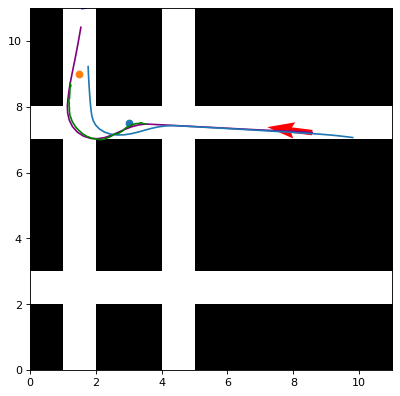

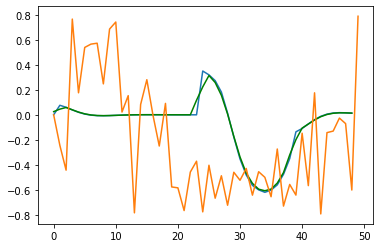

In [170]:
statearr = np.array(statelist)

plt.figure(figsize=(6,6), dpi=80)
plt.imshow(occGrid, extent=[0, gridSize, 0, gridSize], cmap='gray')
#plt.quiver(statearr[:,0] * gridSize, statearr[:,1] * gridSize, np.cos(statearr[:,2]), np.sin(statearr[:,2]), color='purple', scale=16.0, width=0.01)
#plt.quiver(statearr[:,5] * gridSize, statearr[:,6] * gridSize, np.cos(statearr[:,3]), np.sin(statearr[:,3]), color='C0', scale=16.0, width=0.01)
plt.plot(statearr[:,0] * gridSize, statearr[:,1] * gridSize, color='purple')
plt.plot(statearr[:,5] * gridSize, statearr[:,6] * gridSize, color='C0')
plt.scatter(interStarts[:,0] * gridSize, interStarts[:,1] * gridSize)
plt.scatter(interGoals[:,0] * gridSize, interGoals[:,1] * gridSize)
plt.plot(csol[:,0] * gridSize, csol[:,1] * gridSize, color='green')
plt.quiver(start[0] * gridSize, start[1] * gridSize, np.cos(start[2]), np.sin(start[2]), color="red", scale=8.0, width=0.015) # init
plt.quiver(goal[0] * gridSize, goal[1] * gridSize, np.cos(goal[2]), np.sin(goal[2]), color="blue", scale=8.0, width=0.015) # goal
plt.show()

plt.plot(np.arange(statearr.shape[0]), statearr[:, 4])
plt.plot(np.arange(statearr.shape[0]), uniform_filter1d(statearr[:, 4], size=3, origin=0, mode='nearest', axis=0), color='green')
plt.plot(np.arange(csol.shape[0]), csol[:,4])
plt.show()

In [9]:
data = np.vstack((data, np.concatenate((trajSamples[1:], initData[1:], goalData[1:], obstacleData[1:]), axis=1)))
np.savetxt('/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/motion_planning/data/ctrlDataPfollowMazeAsd', data[1:], delimiter=',', fmt='%1.6f')